# **Project Group 6**

#### **Team Members:**
| Name              | Student ID |
| ----------------- | ---------- |
| Danial Bashir   |   XXXXXX   | 
| Danial Rana   |   XXXXXX   |
| Danny Le  |   XXXXXX   |
| Christian Torhaug |   564355   |

Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.arima.model as sm
import statsmodels.stats.diagnostic as sd
from arch import arch_model
from arch.univariate import EGARCH
from mvgarch.mgarch import DCCGARCH
from mvgarch.ugarch import UGARCH

#### Retrieving Data

In [27]:
# S&P 500
spx = pd.read_csv("S&P_500.csv")
spx['Date'] = pd.to_datetime(spx['Date'])
spx["Return"] = spx["Close"].pct_change()
spx = spx.dropna(subset={"Return"})

# Russell 2000
rut = pd.read_csv('Russell_2000.csv')
rut['Date'] = pd.to_datetime(rut['Date'])
rut["Return"] = rut["Close"].pct_change()
rut = rut.dropna(subset={"Return"})

Arima

In [ ]:
best_aic = np.inf
best_order = None
best_model = None

for p in range(6):
    for q in range(6):
        try:
            model = sm.ARIMA(spx['Close'], order=(p, 0, q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, 0, q)
                best_model = model
        except:
            continue
        
print(best_model.summary())
resid = best_model.resid
#model = sm.ARIMA(gasoline_data['Close'], order=(4, 0, 4)).fit()

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. U

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 9499
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -56867.864
Date:                Wed, 26 Mar 2025   AIC                         113743.728
Time:                        18:40:31   BIC                         113772.363
Sample:                             0   HQIC                        113753.445
                               - 9499                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1625.8605      0.000   5.06e+06      0.000    1625.860    1625.861
ar.L1          1.0000   7.08e-05   1.41e+04      0.000       1.000       1.000
ma.L1         -0.7845      0.001  -1298.543      0.0

In [13]:
model = sm.ARIMA(rut['Return'], order=(1, 0, 1)).fit()
resid = model.resid

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Garch

In [28]:
def plot_annualized_volatility(index: pd.DataFrame, model_type: str, symmetry: int):
    model = sm.ARIMA(index['Return'], order=(1, 0, 1)).fit()
    resid = model.resid
    
    p_range = range(1, 5)
    q_range = range(1, 5)
    results = []

    for p in p_range:
        for q in q_range:
            try:
                model = arch_model(resid, vol=model_type, p=p, o=symmetry, q=q, dist='normal', rescale=False)
                fitted_model = model.fit(disp='off')
                results.append({'p': p, 'q': q, 'AIC': fitted_model.aic, 'BIC': fitted_model.bic})
            except Exception as e:
                print(f"Model GARCH({p},{q}) failed: {e}")
                
    results_df = pd.DataFrame(results)
    results_df.sort_values(by='AIC', inplace=True)

    best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
    best_bic_model = results_df.loc[results_df['BIC'].idxmin()]

    print(f"Best model by AIC: GARCH({int(best_aic_model['p'])},{int(best_aic_model['q'])}) with AIC = {best_aic_model['AIC']:.4f}")
    print(f"Best model by BIC: GARCH({int(best_bic_model['p'])},{int(best_bic_model['q'])}) with BIC = {best_bic_model['BIC']:.4f}")

    best_model = arch_model(resid, vol=model_type, p=int(best_aic_model['p']), q=int(best_aic_model['q']), dist='normal', rescale=False)
    fitted = best_model.fit(disp='off')

    # Plot conditional volatility (standard deviation)
    annual_vol = fitted.conditional_volatility*np.sqrt(252)
    mod = "TGARCH" if model_type == "GARCH" and symmetry == 1 else model_type

    plt.figure(figsize=(10, 4))
    plt.plot(index["Date"], annual_vol, label='Conditional Volatility')
    plt.title(f'{mod}({int(best_aic_model["p"])},{int(best_aic_model["q"])}) Conditional Volatility')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    #plt.ylim((0, 0.5))
    plt.legend()
    plt.tight_layout()
    plt.show()

Plotting Annualized Volatility

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\sit

Best model by AIC: GARCH(2,4) with AIC = -61936.2651
Best model by BIC: GARCH(2,4) with BIC = -61878.9945


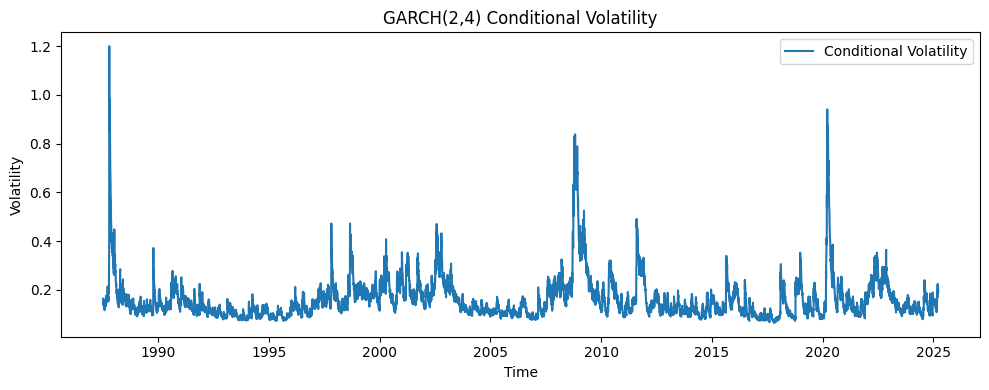

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\sit

Best model by AIC: GARCH(2,3) with AIC = -59350.0381
Best model by BIC: GARCH(2,3) with BIC = -59299.9263


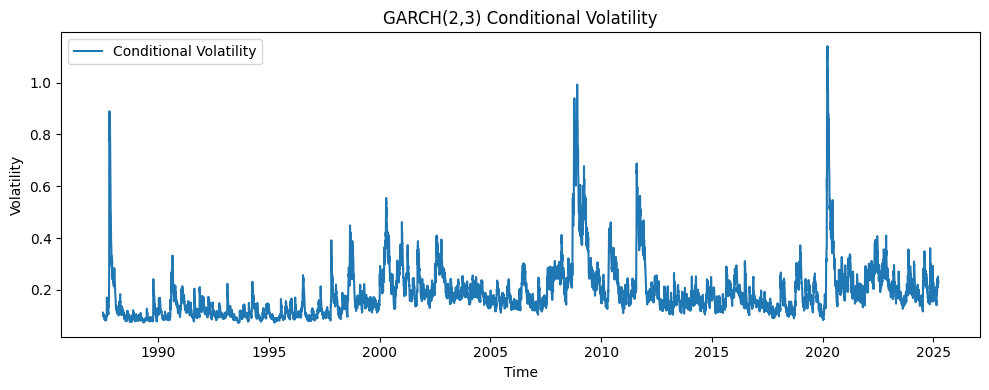

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Best model by AIC: GARCH(3,1) with AIC = -61929.2980
Best model by BIC: GARCH(1,1) with BIC = -61896.7578


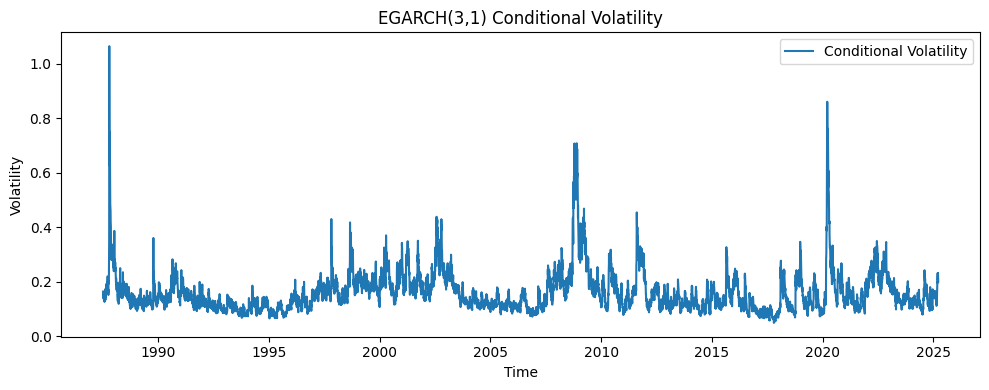

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Best model by AIC: GARCH(4,1) with AIC = -59367.4722
Best model by BIC: GARCH(1,1) with BIC = -59327.0392


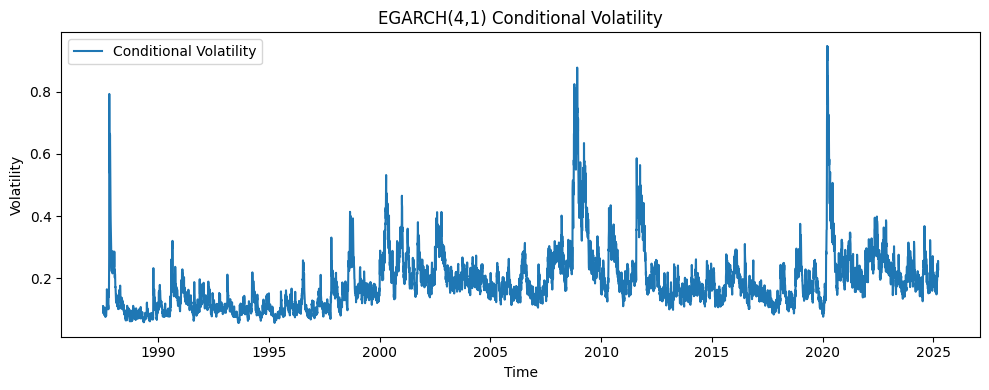

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\sit

Best model by AIC: GARCH(4,1) with AIC = -62206.9681
Best model by BIC: GARCH(1,1) with BIC = -62167.6775


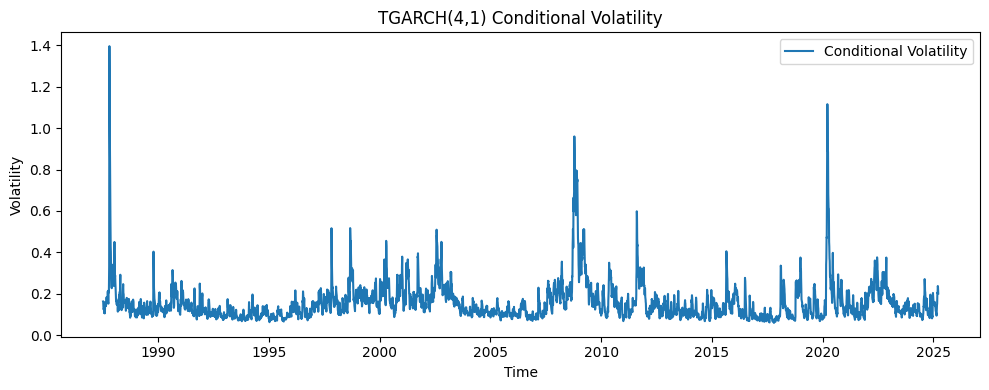

c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\romen\AppData\Local\Programs\Python\Python39\lib\sit

Best model by AIC: GARCH(2,3) with AIC = -59478.8995
Best model by BIC: GARCH(2,3) with BIC = -59421.6289


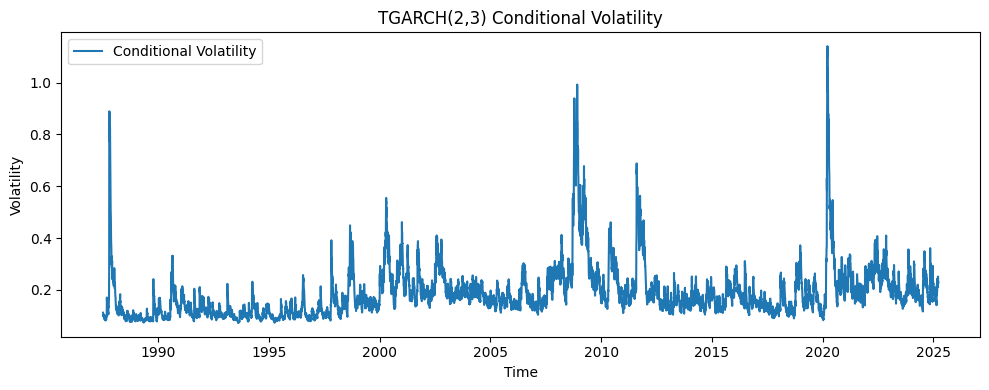

In [29]:
# GARCH
plot_annualized_volatility(spx, "GARCH", 0)
plot_annualized_volatility(rut, "GARCH", 0)

# EGARCH
plot_annualized_volatility(spx, "EGARCH", 0)
plot_annualized_volatility(rut, "EGARCH", 0)

# TGARCH
plot_annualized_volatility(spx, "GARCH", 1)
plot_annualized_volatility(rut, "GARCH", 1)

In [ ]:
p_range = range(1, 5)
q_range = range(1, 5)

results = []

for p in p_range:
    for q in q_range:
        try:
            model = arch_model(resid, vol='GARCH', p=p, q=q, dist='normal')
            fitted_model = model.fit(disp='off')
            results.append({
                'p': p,
                'q': q,
                'AIC': fitted_model.aic,
                'BIC': fitted_model.bic
            })
        except Exception as e:
            print(f"Model GARCH({p},{q}) failed: {e}")
            
results_df = pd.DataFrame(results)
results_df.sort_values(by='AIC', inplace=True)
print(results_df.head())

best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]

print(f"Best model by AIC: GARCH({int(best_aic_model['p'])},{int(best_aic_model['q'])}) with AIC = {best_aic_model['AIC']:.4f}")
print(f"Best model by BIC: GARCH({int(best_bic_model['p'])},{int(best_bic_model['q'])}) with BIC = {best_bic_model['BIC']:.4f}")


Stationarity Test

In [ ]:
model = arch_model(resid*100, vol='GARCH', p=1, q=2, dist='normal')
model = model.fit(disp='off')

params = model.params
stationarity_sum = params['alpha[1]'] + params['beta[1]'] + params['beta[2]']

print(f"The Stationarity sum is {stationarity_sum}")

Tarch

In [ ]:
max_p = 5 
max_q = 5

results = []

for p in range(1, max_p + 1):
    for q in range(1, max_q + 1):
        try:
            model = arch_model(resid, vol='GARCH', p=p, o=1, q=q, dist='normal').fit(disp='off')
            results.append({
                'p': p, 'q': q,
                'AIC': model.aic,
                'BIC': model.bic
            })
        except Exception as e:
            print(f"TARCH({p},{q}) failed to converge.")


results_df = pd.DataFrame(results)

best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]

print(f"Best model by AIC: TARCH({int(best_aic_model['p'])},{int(best_aic_model['q'])}) with AIC = {best_aic_model['AIC']:.4f}")
print(f"Best model by BIC: TARCH({int(best_bic_model['p'])},{int(best_bic_model['q'])}) with BIC = {best_bic_model['BIC']:.4f}")


In [ ]:
combined_data = pd.merge(gasoline_data, brent_data, left_index=True, right_index=True, suffixes=('_Gasoline', '_Brent')).dropna()

# GARCH with Brent Data as exogenous variable

model = arch_model(combined_data['Return_Gasoline'],  vol='GARCH', p=1, q=1, x=combined_data['Return_Brent'], dist='normal')
garchx_result = model.fit(disp='off')

#print(garchx_result.summary())
fitted_volatility = garchx_result.conditional_volatility

plt.figure(figsize=(14, 7))
plt.plot(fitted_volatility, label='Gasoline Conditional Volatility', color='blue', alpha=0.7)
plt.twinx()
plt.plot(combined_data['Return_Brent'], label='Brent Returns', color='red', alpha=0.4)
plt.title('Conditional Volatility of Gasoline Returns with Brent Returns')
plt.xlabel('Date')
plt.ylabel('Volatility / Returns')
plt.legend(loc='upper left')
plt.show()

DCC-Garch

In [ ]:
#The general framework is from https://github.com/jack-tobin/mvgarch because it does not exist a standard framework for Multivariate GARCH

garch = UGARCH(order=(1, 1))
garch.spec(returns=gasoline_data["Return"])
garch.fit()

garch_specs = [UGARCH(order=(1, 1)), UGARCH(order=(1, 1))]
dcc = DCCGARCH()
dcc.spec(ugarch_objs=garch_specs, returns=combined_data[["Return_Gasoline", "Return_Brent"]])
dcc.fit()
dcc.plot()